In [2]:
%load_ext autoreload
%autoreload 2
import sys
import os
import pickle
dir_ = os.path.dirname(os.getcwd())
if dir_ not in sys.path:
    sys.path.append(dir_)
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from comet_ml import Experiment
from comet_ml import API

from sklearn.model_selection import train_test_split
sns.set_theme()

from ift6758.models.utils import preprocess, predict_model,save_metrics_and_models_on_comet,compute_metrics
from ift6758.models.plotter import *
from dotenv import load_dotenv

from sklearn.neural_network import MLPClassifier
from sklearn.utils import resample , shuffle

from imblearn.over_sampling import SMOTE

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
url = 'https://drive.google.com/file/d/1kM__riNHRPx5GsyuOH3yhiql3OZvwmuP/view?usp=sharing'
path = 'https://drive.google.com/uc?export=download&id='+url.split('/')[-2]
model_path = '../models_config/NN/'
df = pd.read_csv(path)

In [5]:
df_train = df[df['season']!=20192020]

In [62]:
list_features = ['empty_net', 'periodTime','period', 'x_coord', 'y_coord','distance','angle','shot_type',\
    'last_event_type', 'last_x_coord', 'last_y_coord','distance_from_last', 'seconds_since_last', \
        'rebound', 'angle_change','speed','powerplay','team_that_shot_nb','other_team_nb']

list_features = ['empty_net', 'periodTime','period', 'x_coord', 'y_coord','distance','angle','shot_type',\
     'last_x_coord', 'last_y_coord','distance_from_last', 'seconds_since_last', \
        'rebound', 'angle_change','speed','powerplay','team_that_shot_nb','other_team_nb']
# preprocess
X, Y ,df_train_preprocessed,_ =  preprocess(df_train,features = list_features, standarize=True)

In [17]:
def sampling(X,Y,method=None):
    X_train, X_val, y_train, y_val = train_test_split(X,Y,random_state = 42, shuffle=True)
    
    if method == 'OverSampling':
        print('OverSampling')
        X_oversampled, y_oversampled = resample(X_train[y_train == 1],
                                                y_train[y_train == 1],
                                                replace=True,
                                                n_samples=X_train[y_train == 0].shape[0],
                                                random_state=42)

        X_train = np.vstack((X_train[y_train == 0], X_oversampled))
        y_train = np.hstack((y_train[y_train == 0], y_oversampled))
        X_train, y_train = shuffle(X_train,y_train,random_state=42)
        
    if method == "UnderSampling" :
        print('UnderSampling')
        X_undersampled, y_undersampled = resample(X_train[y_train == 0],
                                                  y_train[y_train == 0],
                                                  replace=True,
                                                  n_samples=X_train[y_train == 1].shape[0],
                                                   random_state=42)
        X_train = np.vstack((X_train[y_train == 1], X_undersampled))
        y_train = np.hstack((y_train[y_train == 1], y_undersampled))
        X_train, y_train = shuffle(X_train,y_train,random_state=42)
        
    if method == "SMOTE":
        print('SMOTE')
        sm = SMOTE(random_state=42)
        X_train, y_train = sm.fit_resample(X_train, y_train.ravel())

        
    return X_train, X_val, y_train, y_val      

In [63]:
sampling_method = 'SMOTE'
X_train, X_val, y_train, y_val  = sampling(X,Y, method = sampling_method)
print(y_train[:1000])

SMOTE
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 1. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.

### Load model

In [111]:
filename = f'question6_{sampling_method}_NeuralNet.pkl'
model = pickle.load(open(os.path.join(model_path,filename), 'rb'))
print(model)

MLPClassifier(max_iter=30, random_state=1, verbose=True)


### Create new model

In [64]:
model = MLPClassifier(hidden_layer_sizes=(100,50,50,20),warm_start=True,random_state=1, max_iter=5,verbose=True)
best_accuracy = 0.0

In [65]:
for i in range(40):
    model.fit(X_train, y_train)
    y_val_pred = model.predict(X_val)
    df_metrics_results = compute_metrics(y_val,[y_val_pred],model_names=['NN'])
    print(df_metrics_results)
    if best_accuracy < df_metrics_results.Accuracy[0]:
        best_accuracy = df_metrics_results.Accuracy[0]
        print('save best model')
        pkl_filename = f'../models_config/NN/test.pkl'
        with open(pkl_filename, 'wb+') as file:
            pickle.dump(model, file)
    

Iteration 1, loss = 0.55254873
Iteration 2, loss = 0.53191695
Iteration 3, loss = 0.52039009
Iteration 4, loss = 0.51008210
Iteration 5, loss = 0.50111591


C:\Users\xavie\anaconda3\envs\ift6758-conda-env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5) reached and the optimization hasn't converged yet.
  warnings.warn(


  model_name  Accuracy    Recall  Precision   f_score       AUC
0         NN  0.665468  0.674087   0.563333  0.529547  0.674087
save best model
Iteration 6, loss = 0.49243314
Iteration 7, loss = 0.48563274
Iteration 8, loss = 0.47949653
Iteration 9, loss = 0.47338967
Iteration 10, loss = 0.46866007
  model_name  Accuracy    Recall  Precision   f_score       AUC
0         NN  0.692381  0.664209   0.562739  0.540657  0.664209
save best model
Iteration 11, loss = 0.46328635
Iteration 12, loss = 0.45859574
Iteration 13, loss = 0.45441830
Iteration 14, loss = 0.45031429
Iteration 15, loss = 0.44735737
  model_name  Accuracy    Recall  Precision   f_score       AUC
0         NN  0.709291  0.657113   0.562437  0.547059  0.657113
save best model
Iteration 16, loss = 0.44425279
Iteration 17, loss = 0.44082826
Iteration 18, loss = 0.43820496
Iteration 19, loss = 0.43564125
Iteration 20, loss = 0.43376051
  model_name  Accuracy    Recall  Precision   f_score       AUC
0         NN  0.722766  0.65

Iteration 143, loss = 0.36617262
Iteration 144, loss = 0.36563052
Iteration 145, loss = 0.36564960
  model_name  Accuracy    Recall  Precision   f_score       AUC
0         NN  0.754794  0.636468   0.562755  0.562425  0.636468
save best model
Iteration 146, loss = 0.36599387
Iteration 147, loss = 0.36546307
Iteration 148, loss = 0.36537511
Iteration 149, loss = 0.36495014
Iteration 150, loss = 0.36514902
  model_name  Accuracy    Recall  Precision   f_score       AUC
0         NN  0.756212  0.634324   0.562229  0.562218  0.634324
save best model
Iteration 151, loss = 0.36519381
Iteration 152, loss = 0.36472451
Iteration 153, loss = 0.36472505
Iteration 154, loss = 0.36393637
Iteration 155, loss = 0.36427112
  model_name  Accuracy   Recall  Precision   f_score      AUC
0         NN  0.756772  0.63511   0.562657  0.562846  0.63511
save best model
Iteration 156, loss = 0.36451699
Iteration 157, loss = 0.36431692
Iteration 158, loss = 0.36401929
Iteration 159, loss = 0.36348547
Iteration 1

In [66]:
filename = f'test.pkl'
model = pickle.load(open(os.path.join(model_path,filename), 'rb'))
y_val_prob = model.predict_proba(X_val)
y_val_pred = model.predict(X_val)

df_metrics_results = compute_metrics(y_val,[y_val_pred],model_names=['NN'])
df_metrics_results

,model_name,Accuracy,Recall,Precision,f_score,AUC
0,NN,0.759522,0.63597,0.563606,0.56463,0.63597


In [78]:
def best_threshold(model,X_val,y_val):
    best_t = [0,0,0,0,0]
    best_score = [0,0,0,0,0]
    best_thresholds = {'Accuracy':(0,0),"Recall":(0,0),"Precision":(0,0),"f_score":(0,0),"AUC":(0,0)}
    for t in range(1,20):
        y_pred = (model.predict_proba(X_val)[:,1] >= t/20.0).astype(bool)
        df_metrics_results = compute_metrics(y_val,[y_pred],model_names=['NN'])
        
        for key in df_metrics_results.keys()[1:]:
            if best_thresholds[key][0]< df_metrics_results[key][0]:
                best_thresholds[key] = (df_metrics_results[key][0],t/20.0) 
               
     
    for key in best_thresholds.keys():
        print(f'Best threshold base on {key}', best_thresholds[key][1])
        y_val_pred = (model.predict_proba(X_val)[:,1] >= best_thresholds[key][1]).astype(bool)
        df_metrics_results = compute_metrics(y_val,[y_val_pred],model_names=['NN'])
        print(df_metrics_results,'\n')     
            

    

In [79]:
best_threshold(model,X_val,y_val)

Best threshold base on Accuracy 0.95
  model_name  Accuracy    Recall  Precision   f_score       AUC
0         NN   0.90678  0.532609   0.710283  0.538784  0.532609 

Best threshold base on Recall 0.25
  model_name  Accuracy    Recall  Precision   f_score       AUC
0         NN  0.644577  0.646979   0.552666  0.510675  0.646979 

Best threshold base on Precision 0.95
  model_name  Accuracy    Recall  Precision   f_score       AUC
0         NN   0.90678  0.532609   0.710283  0.538784  0.532609 

Best threshold base on f_score 0.75
  model_name  Accuracy    Recall  Precision   f_score       AUC
0         NN  0.853177  0.598112   0.587317  0.592118  0.598112 

Best threshold base on AUC 0.25
  model_name  Accuracy    Recall  Precision   f_score       AUC
0         NN  0.644577  0.646979   0.552666  0.510675  0.646979 



In [60]:
y_val_pred = (model.predict_proba(X_val)[:,1] >= 0.8).astype(bool)
df_metrics_results = compute_metrics(y_val,[y_val_pred],model_names=['NN'])
print(df_metrics_results) 

  model_name  Accuracy    Recall  Precision   f_score       AUC
0         NN  0.655414  0.642745   0.551972  0.514897  0.642745


### Log experiment in Comet

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/princesslove/itf-6758-team-4/c389af2961314320b5fa0bad84bdfc39
COMET INFO:   Metrics:
COMET INFO:     AUC        : 0.5839282736958928
COMET INFO:     Accuracy   : 0.8649230424666227
COMET INFO:     Precision  : 0.5902814525025132
COMET INFO:     Recall     : 0.5839282736958928
COMET INFO:     f_score    : 0.5868942283113892
COMET INFO:     model_name : question6_SMOTE_with_Penalties_t_0.8_NeuralNet
COMET INFO:   Others:
COMET INFO:     Name : question6_SMOTE_with_Penalties_t_0.8_NeuralNet
COMET INFO:   Uploads:
COMET INFO:     confusion-matrix         : 1
COMET INFO:     environment details      : 1
COMET INFO:     figures                  : 4
COMET INFO:     filename                 : 1
COMET INFO:     git metadata             : 1
COMET INFO:    

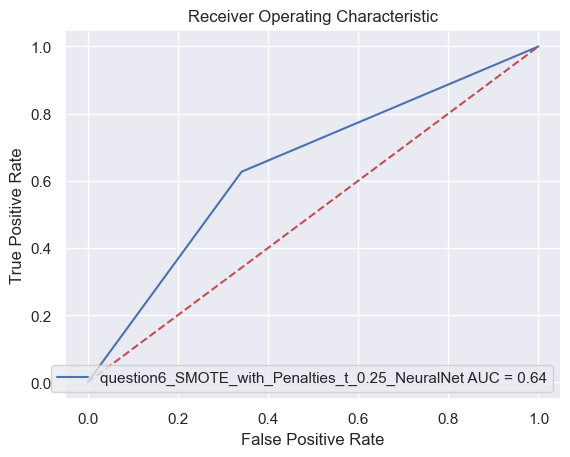

<Figure size 640x480 with 0 Axes>

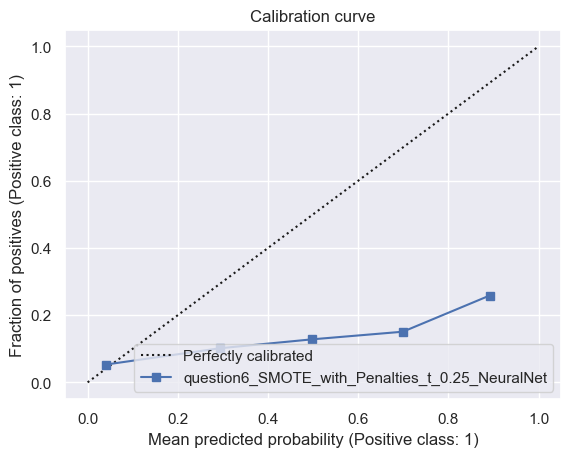

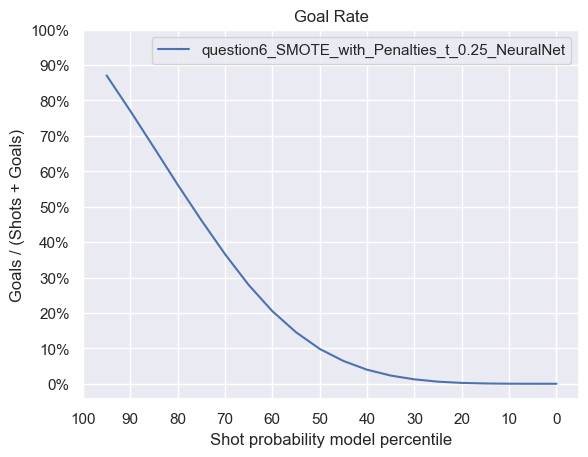

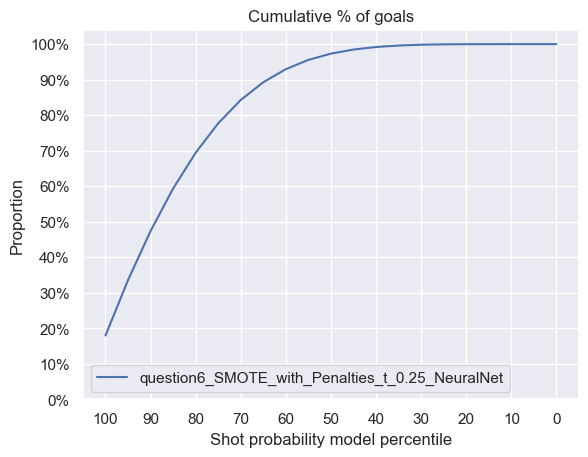

In [61]:
name_experiment = f"question6_{sampling_method}_with_Penalties_t_0.25_NeuralNet"
model_dir = "NN"

save_metrics_and_models_on_comet(model,y_val,y_val_pred,y_val_prob[:,1],model_names=name_experiment,model_dir=model_dir,name_experiment=name_experiment,register_model = True ,sklearn_model=True)